# using "dropout" to mitigate overfitting

A step-by-step walthrough video on this exercise is available [here](https://youtu.be/k-D8i7uSPFU).

"Overfitting" can occur when the model you are using to analyze your data is 'too complex' for the amount of data you have available for training.

In general, the 'complexity' of a neural network model is roughly proportional to the number of 'free parameters' in the model (the network's "weights" and "biases").

So, we can make a neural network model 'simpler' (and thereby reduce it's likelihood of overfitting) by *removing* free parameters from the model (ie, reduce the number of weights and biases in the model).

The idea behind "dropout" is to reduce the number of free parameters in the model *during training* by *randomly* removing (or "dropping out") a user-specified proportion of neurons (along with their weights and biases) from the network during each training step.

Conceptually, the user specifies the 'probability' or 'frequency' with which neurons are 'removed' from the network during training. Typically, a 'dropout probability' of between 0.2-0.5 is used in practice, meaning that 20%-50% of the network's neurons are randomly 'removed' during training.

At each training step, neurons are effectively deleted from the network with the user-specified probability. The 'reduced' network is then trained for a single step using forward- and back-propagation, and the network's remaining parameters are updated, based on the gradients and the specific optimizer used to train the network. During the *next* training step, a *new* set of neurons are 'randomly deleted' from the network, and the *new* 'reduced' network is trained and updated. This 'stochastic' process is repeated throughout the *entire* training process.

During inference or 'prediction', however, *all* the neurons in the network are included. This includes evaluation of overfitting using validation data. During model validation, the *entire network* is used; dropout is *only* used when fitting the model to the training data.

The original paper on 'dropout' from 2012 is available [here](https://arxiv.org/abs/1207.0580).

Fortunately, it is *very easy* to implement "dropout" using the Keras framework in tensorflow; dropout is just another neural network layer!

## implementing dropout in tensorflow

Let's start with a simple densely-connected neural network model. We'll use 2 hidden layers and 32 neural 'units' per layer. We'll assume 1-dimensional input and output shapes, and we'll use ReLU activations throughout (except in the output layer).

In [1]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu, input_shape=[1]))
model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2209 (8.63 KB)
Trainable params: 2209 (8.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


This model has 2,209 trainable parameters.

In the first (input) layer, there are 32 units, each of which has an incoming weight and a bias term, so there are 64 parameters in this layer.

The second layer also has 32 units, but each unit receives an input from *every* unit in the input layer, so *each* neuron in the second layer has 32 incoming weights, plus a bias term. So there are 33 parameters for *each* neuron in the second dense layer. 33*32 = 1056 total trainable parameters in layer 2. The parameter count in layer 3 is the same as for layer 2.

The output layer has a single unit that has 32 weights (one for each unit in the *preceding* layer) and a single bias term, so there are 33 free parameters in the output layer.

Let's add "dropout" to this model.

We'll use a dropout probability of 0.4, specifying that 40% of our neurons should be randomly 'removed' during training. This is a fairly common value used in practice.

The dropout functionality in tensorflow is implemented as a tf.keras.layers object called "Dropout". You specify the dropout probability by setting the

    rate=DPROB

option when you create the tf.keras.layers.Dropout object. In our case, we'll want to set

    rate=0.4

to specify a 40% dropout "rate".

When you add a Dropout layer to your model, it will randomly remove the specified proportion of neurons from the *previous* layer in the network.

In our example, we'll add Dropout layers after *each* existing Dense layer in our network.

In [2]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu, input_shape=[1]))
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(units=1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                64        
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

We can see from the new model's summary that there are Dropout layers after each of the Dense layers in the network (except for the last output layer).

Dropout layers do *not* alter the output shape of the preceding layer, and they *don't* add *any* new trainable parameters to the model.

Also notice that there are *still* 2,209 trainable parameters in our model. Dropout does *not* reduce the number of parameters in the model! Dropout *only* effects the model *during training fit*, not during validation or prediction.

## using Dropout layers to mitigate model overfitting

Let's see if Dropout layers can help mitigate model overfitting.

In the next code cell, we'll start with an end-to-end example that simulates 2-dimensional 'linear' data, partitions the data into "training" and "validation" sub-sets, and fits a rather complex neural network to the training data, using the validation data to assess model overfitting.

Try running the code cell as-is, observing the model's "loss" and "val_loss" during training. Remember that, after training, if the validation loss is much larger than the model's loss on the training data, the model is probably overfitting the training data.

We also plot the training and validation data, and the model's predictions; you can see that the model's predicted values (green +) are often 'right on top of' the training data (blue circles), suggesting possible overfitting to the training data.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                192       
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                

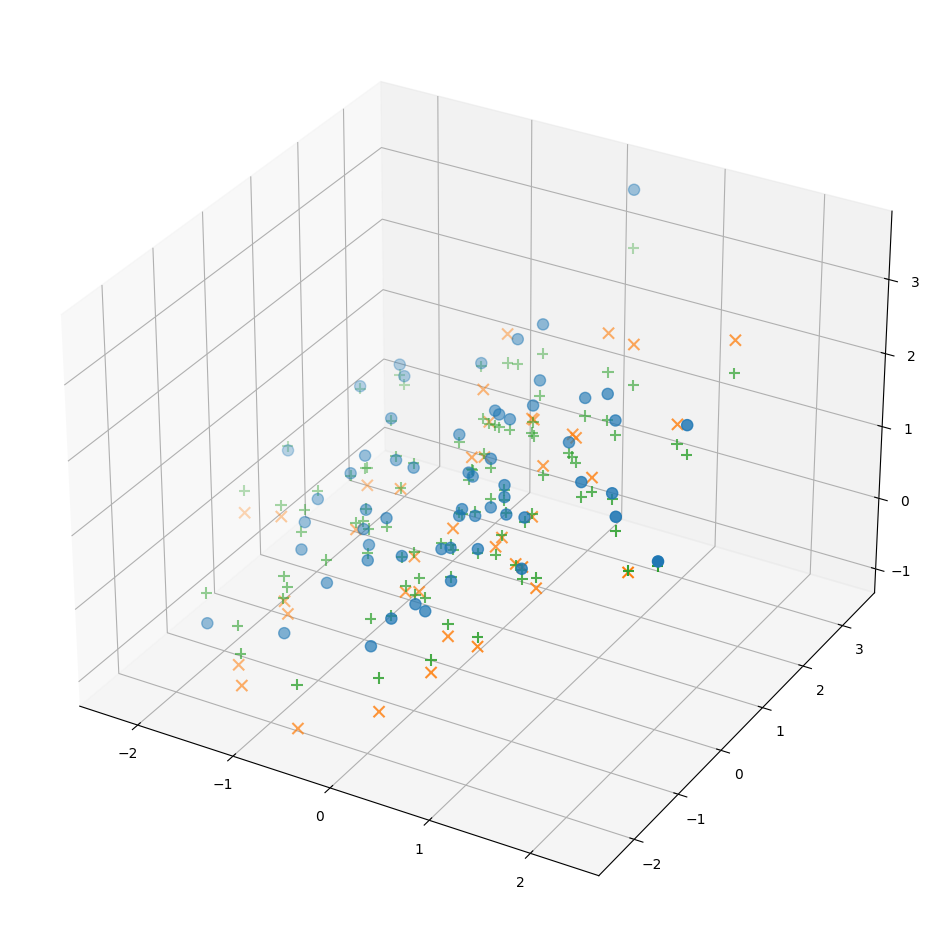

In [4]:
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt
import tensorflow as tf

# simulate data
x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=2,
                                       bias=100.0,
                                       noise=10.0,
                                       random_state=201188)
y /= 100.0

# partition into train and validation subsets
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,
                                                                              y,
                                                                              test_size=40,
                                                                              random_state=221882)

# package training and validation data into tensorflow Dataset objects
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(10)

# build model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu, input_shape=[2]))
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

# fit model
model.fit(train_data, epochs=500, validation_data=valid_data)

# predict using fitted model
y_hat = model.predict(x)

# plot data and model fit
fig = plt.figure(figsize=(12,12))
axs = fig.add_subplot(projection='3d')
axs.scatter(train_x[:,0], train_x[:,1], train_y, marker='o', s=64)
axs.scatter(valid_x[:,0], valid_x[:,1], valid_y, marker='x', s=64)
axs.scatter(x[:,0], x[:,1], y_hat, marker='+', s=64)

When I ran the preceding code cell as-is, the mean-squared error on the *training* data was 0.0044 after 500 epochs of training, while the mean-squared error on the *validation* data was 0.0198 (4.5 *times* the error on the training data!). Your specific results might be slightly different, due to the 'stochastic' nature of "stochastic gradient descent" optimization, but they should be pretty close.

So, the model appears to be overfitting the training data.

Now, go back and __add Dropout layers__ to the model in the preceding code cell, and see if they can help mitigate overfitting.

You should add a new Dropout layer after *each* Dense layer in the existing network (except the final output layer). And set the dropout

    rate=0.4

for each Dropout layer, so 40% of the neurons in the preceding Dense layer will be 'randomly removed' during training. You should end up with 3 Dropout layers in your new model.

After you have implemented your model with Dropout, re-run the code cell and keep track of the model's "loss" and "val_loss" during training.

At the end of 500 epochs of training, is the validation loss closer to the loss on training data? Did adding Dropout layers help reduce overfitting? In the plot, are there *fewer* instances in which the model's predictions (green +) are *exactly on top of* the corresponding training data (blue circles)?